<a href="https://colab.research.google.com/github/OperatorHiKE/Celebrity-recognition-model/blob/main/Final_Project_AP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing packages and libraries

In [ ]:
!pip install keras 
!pip install scikit-learn 
!pip install imbalanced-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import keras
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from keras import Model
from keras.layers import Input
from keras.layers import Conv2D, GlobalAvgPool2D
from keras.layers import Dropout, Activation
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator


In [23]:
lfw_people = fetch_lfw_people(min_faces_per_person=20, color=True, resize=1.0,
                              slice_=(slice(48, 202), slice(48, 202)))

X = lfw_people.images
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('Number of examples: {}'.format(y.shape[0]))
print('The dimensionality of images: {}'.format(X.shape[1:]))
print('Number of unique classes (people): {}'.format(n_classes))

Number of examples: 3023
The dimensionality of images: (154, 154, 3)
Number of unique classes (people): 62


In [ ]:
print(target_names)

['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo Lagos' 'Roh Moo-hyun' 'Rudolph Giuliani' 'Saddam Hussein'
 'Serena Williams' 'Silvio Berlusconi' 'Tiger Woods' 'Tom Das

Colin Powell


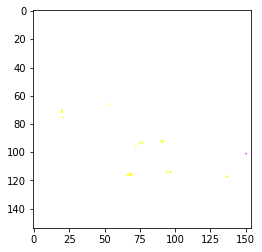

In [ ]:
i = np.random.randint(len(lfw_people.images))
plt.imshow(lfw_people.images[i] * 255)
plt.grid(False)
print(target_names[y[i]])

Deep learning model development


In [ ]:
input = Input(shape=X.shape[1:])                                  
x = Conv2D(12, (3, 3), padding='same', activation='relu')(input)  
x = Conv2D(12, (2, 2), strides=(2, 2), activation='relu')(x)      
x = Conv2D(16, (3, 3), padding='same', activation='relu')(x)      
x = Conv2D(16, (2, 2), strides=(2, 2), activation='relu')(x)      
x = Conv2D(24, (3, 3), padding='same', activation='relu')(x)      
x = Conv2D(24, (2, 2), strides=(2, 2), activation='relu')(x)      
x = Dropout(0.5)(x)                                               
x = Conv2D(n_classes, (1, 1))(x)                                  
x = GlobalAvgPool2D()(x)                                          
output = Activation('softmax')(x)                                 

CNN Architecture


In [ ]:
model = Model(inputs=input, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 154, 154, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 154, 154, 12)      336       
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 77, 12)        588       
                                                                 
 conv2d_2 (Conv2D)           (None, 77, 77, 16)        1744      
                                                                 
 conv2d_3 (Conv2D)           (None, 38, 38, 16)        1040      
                                                                 
 conv2d_4 (Conv2D)           (None, 38, 38, 24)        3480      
                                                                 
 conv2d_5 (Conv2D)           (None, 19, 19, 24)        2328  


**We createa a `DataGenerator` object for adding some data augmentation to prevent overfitting.**

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.1)

### Training


In [22]:
batch_size = 32
test_split = 0.2
learning_rate = 0.001
epochs = 150

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, 
                                                    stratify=y, random_state=21)

sampling_targets = np.maximum([128] * n_classes, np.bincount(y_train))
ratio_dict = dict(zip(range(n_classes), sampling_targets))
ros = RandomOverSampler(sampling_strategy=ratio_dict, random_state=21)

X_train_shape = X_train.shape
X_train = np.reshape(X_train, (X_train_shape[0], -1))
X_train, y_train = ros.fit_resample(X_train, y_train)
X_train = np.reshape(X_train, (len(X_train),) + X_train_shape[1:])

y_train = keras.utils.to_categorical(y_train, n_classes)
y_test = keras.utils.to_categorical(y_test, n_classes)

model = Model(inputs=input, outputs=output)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Nadam(learning_rate),
              metrics=['accuracy'])

history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

<ipython-input-10-cf289518f6b3>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),


Epoch 1/150
259/259 [==============================] - 55s 178ms/step - loss: 4.2118 - accuracy: 0.0458 - val_loss: 3.9619 - val_accuracy: 0.1752
Epoch 2/150
259/259 [==============================] - 45s 174ms/step - loss: 4.0192 - accuracy: 0.0537 - val_loss: 3.8929 - val_accuracy: 0.1686
Epoch 3/150
259/259 [==============================] - 46s 177ms/step - loss: 3.8944 - accuracy: 0.0660 - val_loss: 3.7191 - val_accuracy: 0.1587
Epoch 4/150
259/259 [==============================] - 47s 180ms/step - loss: 3.7001 - accuracy: 0.0951 - val_loss: 3.4666 - val_accuracy: 0.1950
Epoch 5/150
259/259 [==============================] - 45s 174ms/step - loss: 3.5675 - accuracy: 0.1086 - val_loss: 3.3685 - val_accuracy: 0.1967
Epoch 6/150
259/259 [==============================] - 46s 177ms/step - loss: 3.3538 - accuracy: 0.1452 - val_loss: 3.3485 - val_accuracy: 0.1917
Epoch 7/150
259/259 [==============================] - 45s 172ms/step - loss: 3.2230 - accuracy: 0.1660 - val_loss: 3.1190 -

In [ ]:
model.save('model.h5')

### Results

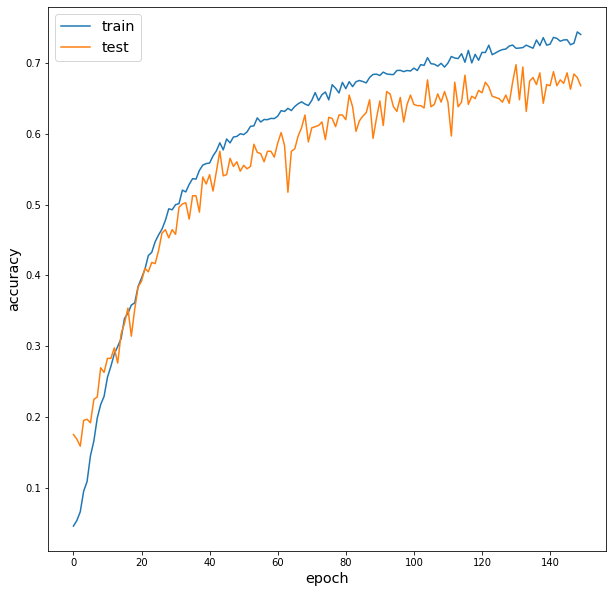

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('accuracy', fontsize='x-large')
plt.xlabel('epoch', fontsize='x-large')
plt.legend(['train', 'test'], loc='upper left', fontsize='x-large')


**Get predictions from the test set to visualize results.**

In [ ]:
y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)
y_pred = np.argmax(y_pred, axis=1)

1/1 [==============================] - 2s 2s/step


Confusion Matrix

In [ ]:
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(0, len(classes), 2)
    plt.xticks(tick_marks, classes[tick_marks], rotation=90)
    plt.yticks(tick_marks, classes[tick_marks])
    plt.ylabel('True label', fontsize='x-large')
    plt.xlabel('Predicted label', fontsize='x-large')

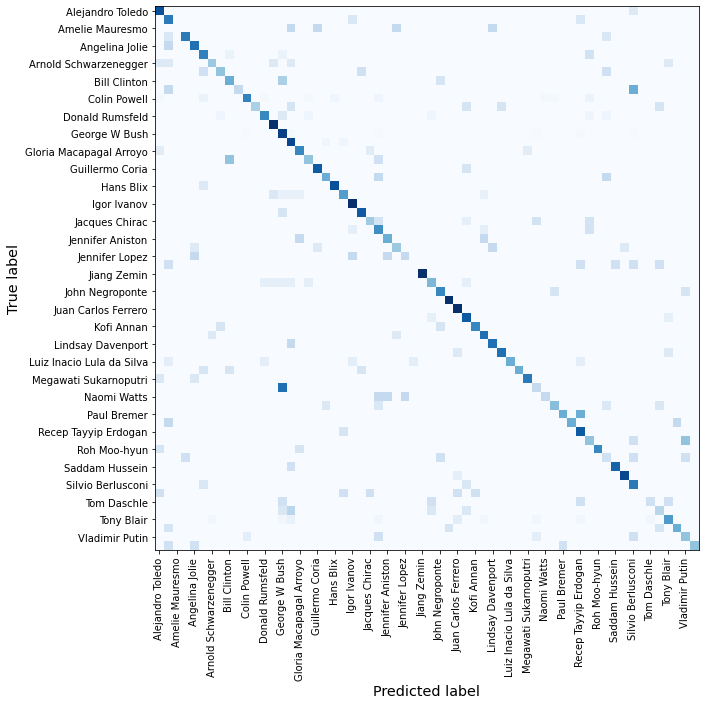

In [ ]:
plt.figure(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cm, classes=target_names)
plt.grid(False)

In [ ]:
def plot_barh(labels, values):
    fig = plt.figure(figsize=(12, 8))
    y_pos = np.arange(len(labels))
    plt.barh(y_pos, values, align='center', alpha=0.5)
    plt.yticks(y_pos, labels)
    plt.xticks(np.arange(0.0, 1.0, 0.05))
    plt.xlabel('accuracy', fontsize='x-large')
    plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)
    axes = plt.gca()
    axes.set_xlim([0.0, 1.0])
    axes.axvline(np.mean(values), color='green', linewidth=2)
    plt.tight_layout()

In [ ]:
class_accuracies = [cm[i, i] for i in range(cm.shape[0])]

<ipython-input-16-0ea0512b6380>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.grid(color='black', linestyle='-', linewidth=0.5)


average accuracy: 58.1%


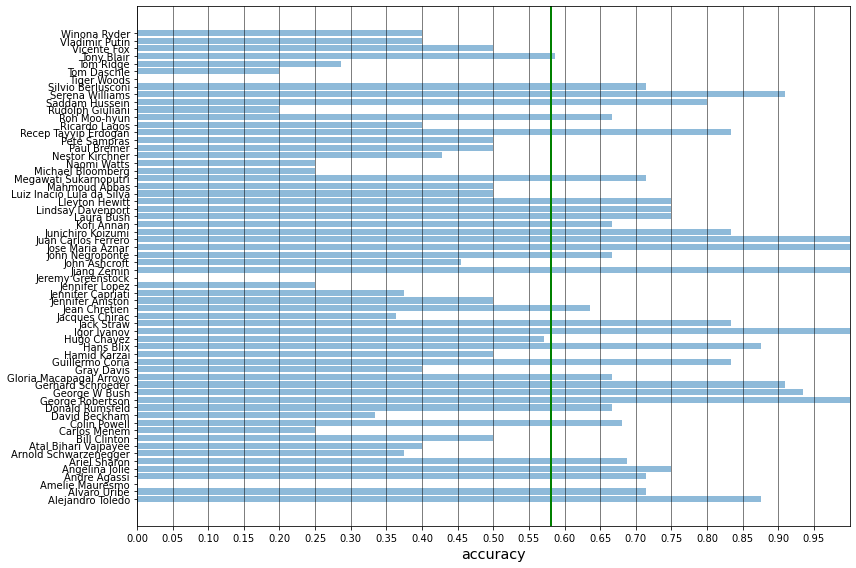

In [ ]:
plot_barh(target_names, class_accuracies)
print('Average accuracy: {}%'.format(np.round(np.mean(class_accuracies) * 100.0, 1)))

Calculating recall of all true labeled values

In [ ]:
recall = np.diag(cm) / np.sum (cm, axis = 1)
np.mean(recall)

0.5807113651631752

Note for a teacher:
We shifted from the Idea of Mental Health bot because we encounterd a problem which is beyound from our understanding and knowledge base.
We tried our best, but we the problem remained after 5 days of working, including bonus days. We changed the idea to a recognition of celebrities.
There is a link to a Colab notebook of Mental AI bot, if you want to see our work: https://colab.research.google.com/drive/1db4wDj7yFpK0f9SqpyYD99RGikCbxE81?usp=sharing 
I hope our grade will not decrease so much. Nevertheless, thank you for your help